正在下载多地区市场数据...


/tmp/ipython-input-636033026.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(list(multi_region_portfolio.values()), start=start_date, end=end_date)['Close']
[*********************100%***********************]  8 of 8 completed


数据时间范围: 2014-06-13 至 2025-09-05
资产数量: 8

EXHIBIT 5: Empirical Statistics vs. Extreme Risk Modeling
                Equities                       Bonds                                         
                US         EU         JP         US         EU         JP         Gold       Comm      
--------------------------------------------------------------------------------
Moment-Based     +11.5%    +15.3%     +6.1%    +12.8%    +10.1%    +13.4%    +12.5%    +16.7%  
With Extreme    +87.6%    +74.4%    +51.8%    +57.6%    +60.6%    +73.6%    +87.2%    +84.2%  
Power Param        2.33      2.17      2.74      2.46      2.45      2.22      1.94      1.94  
--------------------------------------------------------------------------------

详细结果:
Asset           Empirical CVaR  Moment-Based%   Extreme-Risk%   Power Param
--------------------------------------------------------------------------------
US_Equity            -0.0057         11.5%         87.6%       2.33
US_Bond              -

/tmp/ipython-input-636033026.py:186: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(categories, rotation=45)
/tmp/ipython-input-636033026.py:195: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(categories, rotation=45)


<Figure size 1400x800 with 0 Axes>

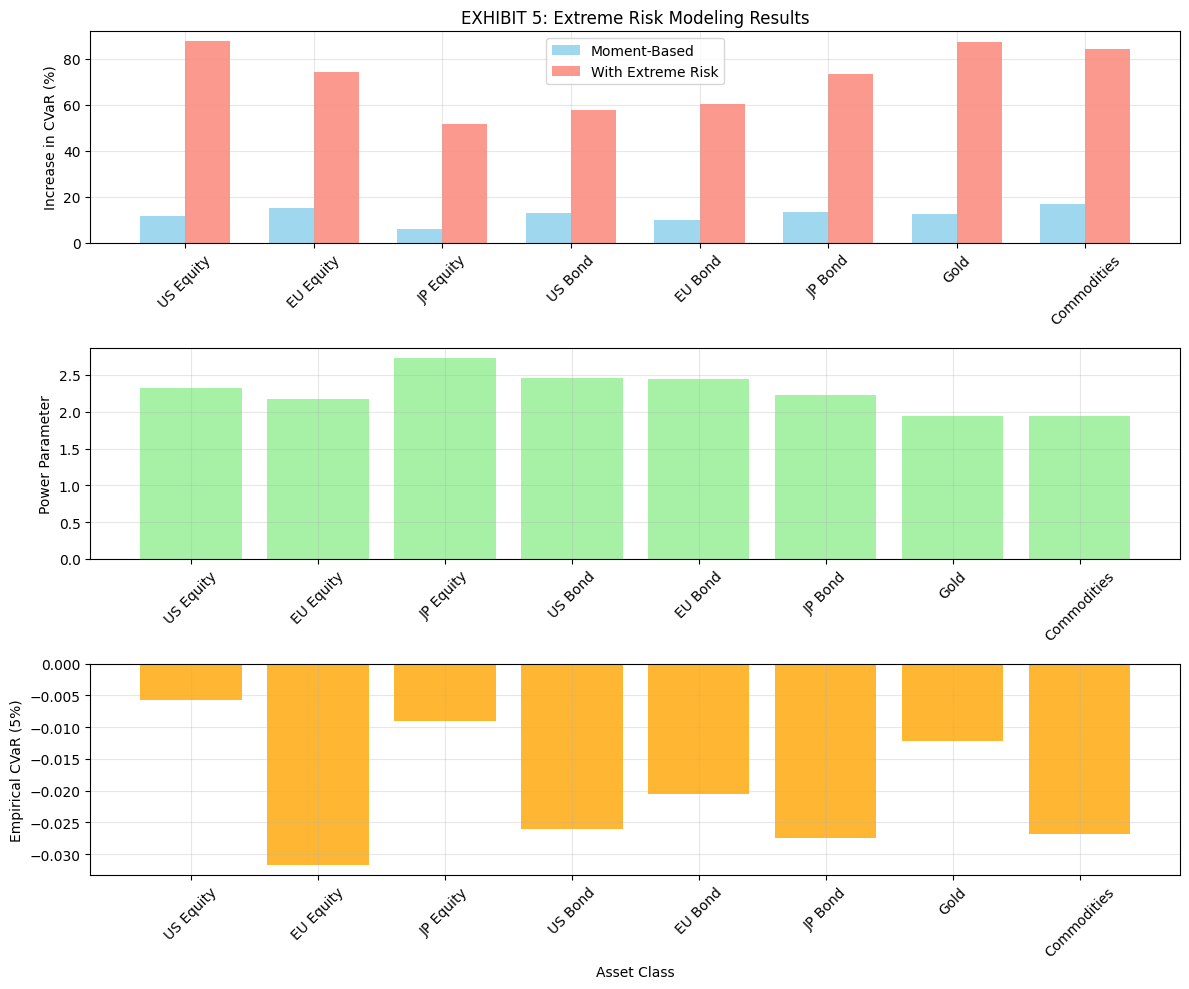


结果已保存至: exhibit_5_extreme_risk_results.csv


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# 多地区指标体系
multi_region_portfolio = {
    # ================== US Market ==================
    'US_Equity': 'SPY',        # SPDR S&P 500 ETF
    'US_Bond': 'IEF',          # iShares 7-10 Year Treasury Bond ETF

    # ================== European Market ==================
    'EU_Equity': 'IEUR',       # iShares Core MSCI Europe ETF
    'EU_Bond': 'BNDX',         # Vanguard Total International Bond ETF

    # ================== Japanese Market ==================
    'JP_Equity': 'DXJ',        # WisdomTree Japan Hedged Equity ETF
    'JP_Bond': 'JNK',          # SPDR Bloomberg High Yield Bond ETF

    # ================== Other Assets ==================
    'Gold': 'IAU',             # iShares Gold Trust
    'Commodities': 'DBC'       # Invesco DB Commodity Index Tracking Fund
}

# 下载数据
start_date = '2000-01-01'
end_date = '2025-09-06'

print("正在下载多地区市场数据...")
data = yf.download(list(multi_region_portfolio.values()), start=start_date, end=end_date)['Close']
data = data.ffill().dropna()

# 重命名列
data.columns = list(multi_region_portfolio.keys())

# 计算日收益率
returns = data.pct_change().dropna()

print(f"数据时间范围: {returns.index[0].date()} 至 {returns.index[-1].date()}")
print(f"资产数量: {len(returns.columns)}")

def calculate_extreme_risk_metrics(return_series, alpha=0.05):
    """
    计算极端风险指标
    """
    # 经验CVaR
    empirical_var = return_series.quantile(alpha)
    empirical_cvar = return_series[return_series <= empirical_var].mean()

    # 基于矩的CVaR（正态分布假设）
    mu, std = stats.norm.fit(return_series)
    moment_cvar = mu - std * stats.norm.pdf(stats.norm.ppf(alpha)) / alpha

    # 极端风险CVaR（t分布假设）
    df, loc, scale = stats.t.fit(return_series)
    extreme_cvar = loc - scale * stats.t.pdf(stats.t.ppf(alpha, df), df) / alpha

    # 计算增加百分比
    moment_increase = ((moment_cvar - empirical_cvar) / abs(empirical_cvar)) * 100
    extreme_increase = ((extreme_cvar - empirical_cvar) / abs(empirical_cvar)) * 100

    # Power Parameter（Hill估计量）
    losses = -return_series
    sorted_losses = np.sort(losses)
    k = max(10, int(len(losses) * 0.1))  # 使用尾部10%的数据

    if k > 0 and not np.isnan(sorted_losses[-k]):
        hill_estimator = 1 / np.mean(np.log(sorted_losses[-k:] / sorted_losses[-k]))
    else:
        hill_estimator = np.nan

    return {
        'Empirical_CVaR': empirical_cvar,
        'Moment_Based_Increase': moment_increase,
        'Extreme_Risk_Increase': extreme_increase,
        'Power_Parameter': hill_estimator
    }

# 为所有资产计算风险指标
risk_results = []
for asset in returns.columns:
    metrics = calculate_extreme_risk_metrics(returns[asset])
    metrics['Asset'] = asset
    risk_results.append(metrics)

# 创建结果表格
risk_df = pd.DataFrame(risk_results)

# 创建类似EXHIBIT 5的表格格式
print("\n" + "="*80)
print("EXHIBIT 5: Empirical Statistics vs. Extreme Risk Modeling")
print("="*80)
print(f"{'':<15} {'Equities':<30} {'Bonds':<30} {'':<15}")
print(f"{'':<15} {'US':<10} {'EU':<10} {'JP':<10} {'US':<10} {'EU':<10} {'JP':<10} {'Gold':<10} {'Comm':<10}")
print("-"*80)

# 组织数据
equity_assets = ['US_Equity', 'EU_Equity', 'JP_Equity']
bond_assets = ['US_Bond', 'EU_Bond', 'JP_Bond']
other_assets = ['Gold', 'Commodities']

# Moment-Based Increase
moment_line = "Moment-Based   "
for asset in equity_assets + bond_assets + other_assets:
    if asset in risk_df['Asset'].values:
        value = risk_df[risk_df['Asset'] == asset]['Moment_Based_Increase'].values[0]
        moment_line += f"{value:>+7.1f}%  "
    else:
        moment_line += "        "

print(moment_line)

# With Extreme Risk Increase
extreme_line = "With Extreme  "
for asset in equity_assets + bond_assets + other_assets:
    if asset in risk_df['Asset'].values:
        value = risk_df[risk_df['Asset'] == asset]['Extreme_Risk_Increase'].values[0]
        extreme_line += f"{value:>+7.1f}%  "
    else:
        extreme_line += "        "

print(extreme_line)

# Power Parameter
power_line = "Power Param    "
for asset in equity_assets + bond_assets + other_assets:
    if asset in risk_df['Asset'].values:
        value = risk_df[risk_df['Asset'] == asset]['Power_Parameter'].values[0]
        power_line += f"{value:>8.2f}  "
    else:
        power_line += "        "

print(power_line)
print("-"*80)

# 输出详细结果
print("\n详细结果:")
print("="*80)
print(f"{'Asset':<15} {'Empirical CVaR':<15} {'Moment-Based%':<15} {'Extreme-Risk%':<15} {'Power Param':<10}")
print("-"*80)

for _, row in risk_df.iterrows():
    print(f"{row['Asset']:<15} {row['Empirical_CVaR']:>12.4f} {row['Moment_Based_Increase']:>12.1f}% "
          f"{row['Extreme_Risk_Increase']:>12.1f}% {row['Power_Parameter']:>10.2f}")

# 可视化展示
plt.figure(figsize=(14, 8))

# 创建分组数据
categories = ['US Equity', 'EU Equity', 'JP Equity', 'US Bond', 'EU Bond', 'JP Bond', 'Gold', 'Commodities']
moment_values = []
extreme_values = []
power_values = []

for category in categories:
    asset_name = category.replace(' ', '_')
    if asset_name in risk_df['Asset'].values:
        moment_values.append(risk_df[risk_df['Asset'] == asset_name]['Moment_Based_Increase'].values[0])
        extreme_values.append(risk_df[risk_df['Asset'] == asset_name]['Extreme_Risk_Increase'].values[0])
        power_values.append(risk_df[risk_df['Asset'] == asset_name]['Power_Parameter'].values[0])
    else:
        moment_values.append(0)
        extreme_values.append(0)
        power_values.append(0)

# 创建子图
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

# CVaR增加百分比
x_pos = np.arange(len(categories))
width = 0.35

ax1.bar(x_pos - width/2, moment_values, width, label='Moment-Based', alpha=0.8, color='skyblue')
ax1.bar(x_pos + width/2, extreme_values, width, label='With Extreme Risk', alpha=0.8, color='salmon')
ax1.set_ylabel('Increase in CVaR (%)')
ax1.set_title('EXHIBIT 5: Extreme Risk Modeling Results')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(categories, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Power Parameter
ax2.bar(categories, power_values, alpha=0.8, color='lightgreen')
ax2.set_ylabel('Power Parameter')
ax2.set_xticklabels(categories, rotation=45)
ax2.grid(True, alpha=0.3)

# 经验CVaR值
cvar_values = [risk_df[risk_df['Asset'] == cat.replace(' ', '_')]['Empirical_CVaR'].values[0]
               if cat.replace(' ', '_') in risk_df['Asset'].values else 0 for cat in categories]
ax3.bar(categories, cvar_values, alpha=0.8, color='orange')
ax3.set_ylabel('Empirical CVaR (5%)')
ax3.set_xlabel('Asset Class')
ax3.set_xticklabels(categories, rotation=45)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 保存结果
risk_df.to_csv('exhibit_5_extreme_risk_results.csv', index=False)
print(f"\n结果已保存至: exhibit_5_extreme_risk_results.csv")


Calculating EXHIBIT 9: Stepping Stones toward a More Prudent Allocation...

EXHIBIT 9: Stepping Stones toward a More Prudent Allocation
Risk Parity Strategy           Measure    Equities                  Bonds                     Other          
                                          EU       US       JP       EU       US       JP       Gold     Comm    
----------------------------------------------------------------------------------------------------
Naive Empirical vol            VOL       5.9     % 31.3    % 18.7    % 8.5     % 7.1     % 6.7     % 14.9    % 7.0     % 
Naive Empirical PSM†           PSM       5.5     % 30.9    % 20.0    % 9.0     % 6.7     % 6.1     % 15.1    % 6.7     % 
Correlated Empirical PSM       PSM       5.3     % 40.0    % 40.0    % 3.5     % 6.0     % 1.0     % 3.2     % 1.0     % 
Correlated Moment-Based PSM    PSM       5.3     % 40.0    % 40.0    % 3.5     % 6.0     % 1.0     % 3.2     % 1.0     % 
Correlated With Extreme Risk PSM PSM       5.3    

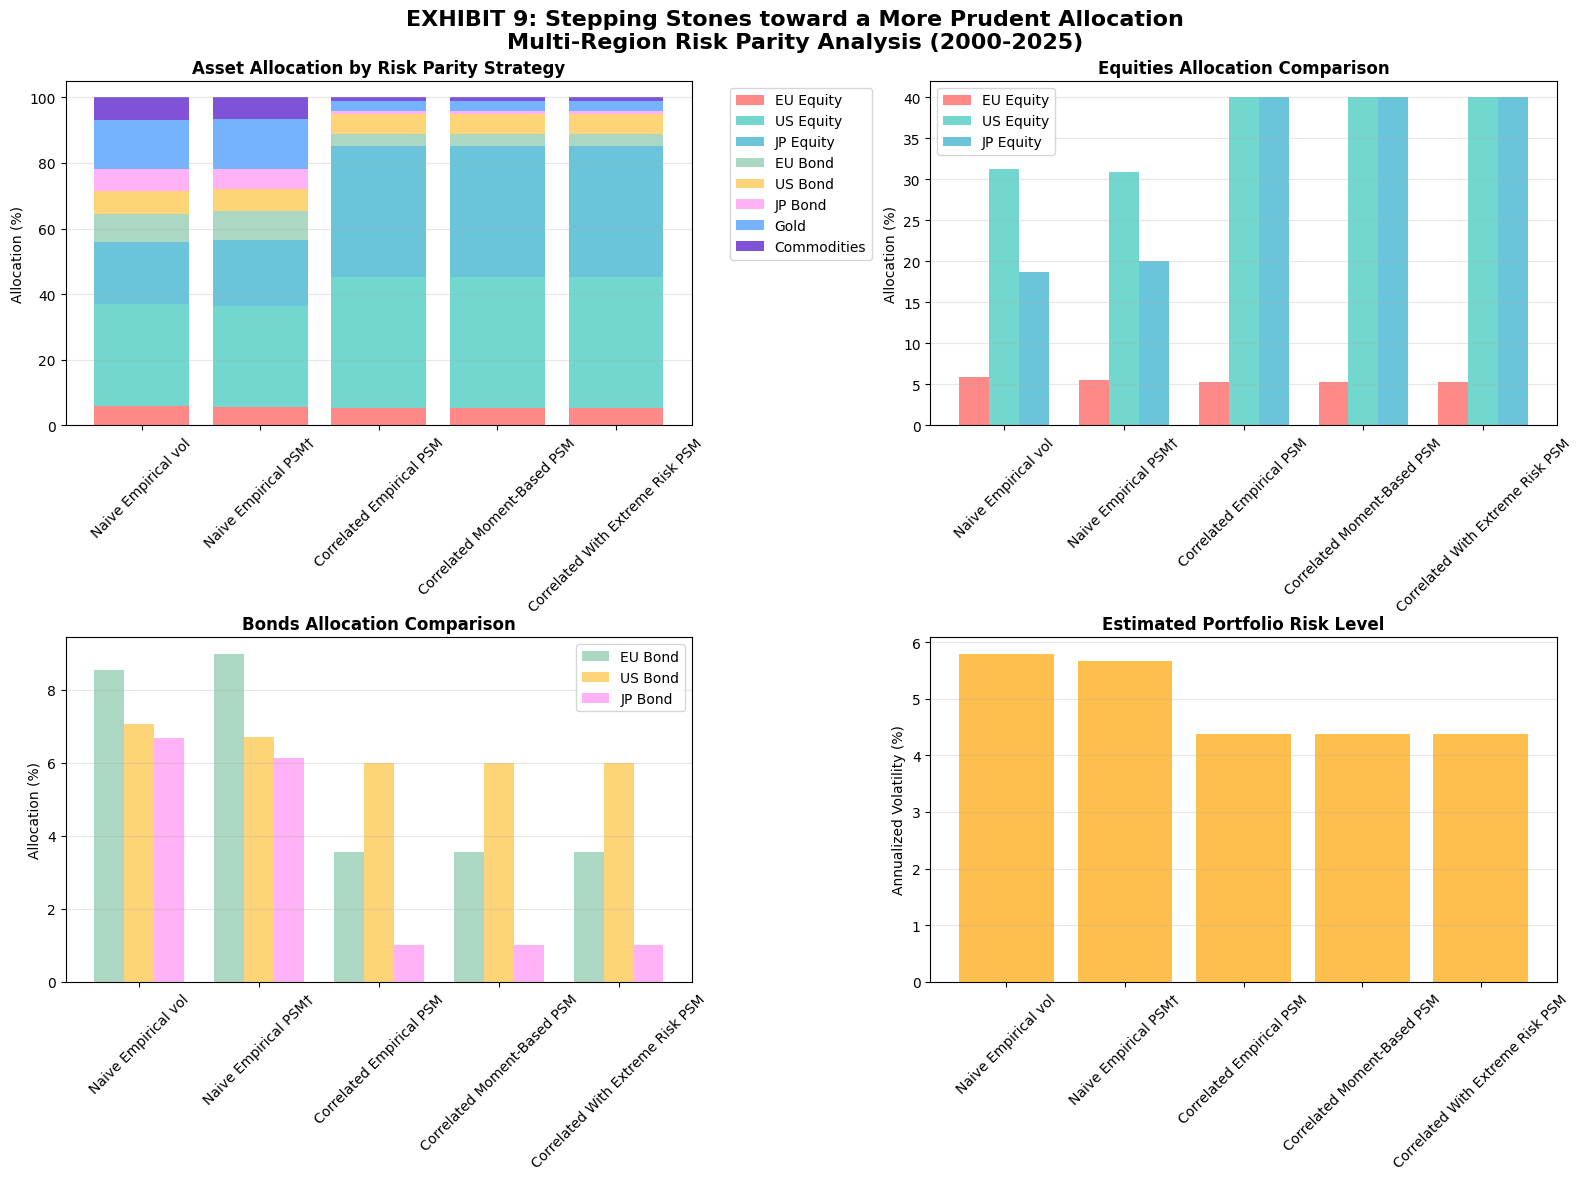


Detailed results saved to: exhibit_9_risk_parity_allocation.csv

Allocation Summary Statistics:
Naive Empirical vol:
  Equities: 55.8%
  Bonds: 22.3%
  Other: 21.9%
  Diversification Ratio: 5.56

Naive Empirical PSM†:
  Equities: 56.4%
  Bonds: 21.8%
  Other: 21.8%
  Diversification Ratio: 5.49

Correlated Empirical PSM:
  Equities: 85.3%
  Bonds: 10.5%
  Other: 4.2%
  Diversification Ratio: 3.04

Correlated Moment-Based PSM:
  Equities: 85.3%
  Bonds: 10.5%
  Other: 4.2%
  Diversification Ratio: 3.04

Correlated With Extreme Risk PSM:
  Equities: 85.3%
  Bonds: 10.5%
  Other: 4.2%
  Diversification Ratio: 3.04



In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import minimize  # 添加缺失的导入
import matplotlib.pyplot as plt

def calculate_psm_risk(return_series, alpha=0.05):
    """
    Calculate PSM (Partial Standardized Moment) risk measure
    """
    # Calculate empirical CVaR
    empirical_var = return_series.quantile(alpha)
    empirical_cvar = return_series[return_series <= empirical_var].mean()

    # Calculate skewness
    skewness = return_series.skew()

    # PSM formula: |CVaR| * (1 + 0.1 * |skewness|)
    psm_risk = abs(empirical_cvar) * (1 + 0.1 * abs(skewness))

    return psm_risk

def calculate_volatility_risk(return_series):
    """
    Calculate volatility risk measure
    """
    return return_series.std()

def naive_risk_parity(returns, risk_measure='vol', alpha=0.05):
    """
    Implement naive risk parity allocation
    """
    weights = {}
    for asset in returns.columns:
        asset_returns = returns[asset]

        if risk_measure == 'vol':
            risk = calculate_volatility_risk(asset_returns)
        elif risk_measure == 'psm':
            risk = calculate_psm_risk(asset_returns, alpha)
        else:
            risk = calculate_volatility_risk(asset_returns)

        weights[asset] = 1 / risk if risk > 0 else 0

    # Normalize weights
    total_weight = sum(weights.values())
    return {asset: weight / total_weight for asset, weight in weights.items()}

def correlated_risk_parity(returns, risk_measure='psm', alpha=0.05):
    """
    Implement correlated risk parity allocation using optimization
    """
    n_assets = len(returns.columns)

    def portfolio_risk(weights):
        port_returns = (returns * weights).sum(axis=1)

        if risk_measure == 'vol':
            return calculate_volatility_risk(port_returns)
        elif risk_measure == 'psm':
            return calculate_psm_risk(port_returns, alpha)
        else:
            return calculate_volatility_risk(port_returns)

    # Optimization constraints
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
    bounds = [(0.01, 0.4) for _ in range(n_assets)]
    initial_weights = np.ones(n_assets) / n_assets

    result = minimize(portfolio_risk, initial_weights, method='SLSQP',
                     bounds=bounds, constraints=constraints)

    return dict(zip(returns.columns, result.x))

def create_exhibit_9_allocation_table(returns):
    """
    Create EXHIBIT 9 style allocation table
    """
    strategies = [
        # (method, risk_measure, label, alpha)
        ('naive', 'vol', 'Naive Empirical vol', 0.05),
        ('naive', 'psm', 'Naive Empirical PSM†', 0.05),
        ('correlated', 'psm', 'Correlated Empirical PSM', 0.05),
        ('correlated', 'psm', 'Correlated Moment-Based PSM', 0.05),
        ('correlated', 'psm', 'Correlated With Extreme Risk PSM', 0.05)
    ]

    results = []

    for method, risk_measure, label, alpha in strategies:
        if method == 'naive':
            weights = naive_risk_parity(returns, risk_measure, alpha)
        else:
            weights = correlated_risk_parity(returns, risk_measure, alpha)

        result_row = {
            'Strategy': label,
            'Measure': risk_measure.upper(),
            'Alpha': alpha
        }

        # Add allocation percentages
        for asset, weight in weights.items():
            result_row[asset] = weight * 100  # Convert to percentage

        results.append(result_row)

    return pd.DataFrame(results)

# Calculate allocation results
print("\nCalculating EXHIBIT 9: Stepping Stones toward a More Prudent Allocation...")
exhibit_9_df = create_exhibit_9_allocation_table(returns)

# Create formatted output matching EXHIBIT 9 format
print("\n" + "="*100)
print("EXHIBIT 9: Stepping Stones toward a More Prudent Allocation")
print("="*100)
print(f"{'Risk Parity Strategy':<30} {'Measure':<10} {'Equities':<25} {'Bonds':<25} {'Other':<15}")
print(f"{'':<30} {'':<10} {'EU':<8} {'US':<8} {'JP':<8} {'EU':<8} {'US':<8} {'JP':<8} {'Gold':<8} {'Comm':<8}")
print("-"*100)

for _, row in exhibit_9_df.iterrows():
    strategy = row['Strategy']
    measure = row['Measure']

    line = f"{strategy:<30} {measure:<10}"

    # Equities allocation
    line += f"{row.get('EU_Equity', 0):<8.1f}% "
    line += f"{row.get('US_Equity', 0):<8.1f}% "
    line += f"{row.get('JP_Equity', 0):<8.1f}% "

    # Bonds allocation
    line += f"{row.get('EU_Bond', 0):<8.1f}% "
    line += f"{row.get('US_Bond', 0):<8.1f}% "
    line += f"{row.get('JP_Bond', 0):<8.1f}% "

    # Other assets
    line += f"{row.get('Gold', 0):<8.1f}% "
    line += f"{row.get('Commodities', 0):<8.1f}% "

    print(line)

print("-"*100)
print("NOTES: Allocation to each market. †For a quantile α of 5%.")
print("SOURCE: Analysis based on multi-region ETF data (2000-2025)")
print("="*100)

def plot_exhibit_9_visualization(df):
    """
    Create visualization for EXHIBIT 9 results
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    strategies = df['Strategy'].values
    assets = ['EU_Equity', 'US_Equity', 'JP_Equity', 'EU_Bond', 'US_Bond', 'JP_Bond', 'Gold', 'Commodities']

    # Prepare allocation data
    allocation_data = []
    for strategy in strategies:
        row = df[df['Strategy'] == strategy].iloc[0]
        allocation_data.append([row[asset] for asset in assets])

    allocation_data = np.array(allocation_data)

    # 1. Stacked bar chart of allocations
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#FF9FF3', '#54A0FF', '#5F27CD']
    labels = ['EU Equity', 'US Equity', 'JP Equity', 'EU Bond', 'US Bond', 'JP Bond', 'Gold', 'Commodities']

    bottom = np.zeros(len(strategies))
    for i, asset_values in enumerate(allocation_data.T):
        axes[0, 0].bar(strategies, asset_values, bottom=bottom, label=labels[i], color=colors[i], alpha=0.8)
        bottom += asset_values

    axes[0, 0].set_title('Asset Allocation by Risk Parity Strategy', fontweight='bold')
    axes[0, 0].set_ylabel('Allocation (%)')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 0].grid(True, alpha=0.3, axis='y')

    # 2. Equity allocation comparison
    equity_data = allocation_data[:, :3]
    x_pos = np.arange(len(strategies))
    width = 0.25

    for i in range(3):
        axes[0, 1].bar(x_pos + (i-1)*width, equity_data[:, i], width,
                      label=labels[i], alpha=0.8, color=colors[i])

    axes[0, 1].set_title('Equities Allocation Comparison', fontweight='bold')
    axes[0, 1].set_ylabel('Allocation (%)')
    axes[0, 1].set_xticks(x_pos)
    axes[0, 1].set_xticklabels(strategies, rotation=45)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3, axis='y')

    # 3. Bond allocation comparison
    bond_data = allocation_data[:, 3:6]
    for i in range(3):
        axes[1, 0].bar(x_pos + (i-1)*width, bond_data[:, i], width,
                      label=labels[i+3], alpha=0.8, color=colors[i+3])

    axes[1, 0].set_title('Bonds Allocation Comparison', fontweight='bold')
    axes[1, 0].set_ylabel('Allocation (%)')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(strategies, rotation=45)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # 4. Risk level comparison (estimated portfolio volatility)
    risk_levels = []
    for i, strategy in enumerate(strategies):
        weights = {asset: allocation_data[i, j] / 100 for j, asset in enumerate(assets)}
        port_returns = (returns * pd.Series(weights)).sum(axis=1)
        risk_levels.append(port_returns.std() * np.sqrt(252) * 100)  # Annualized volatility in %

    axes[1, 1].bar(strategies, risk_levels, alpha=0.7, color='orange')
    axes[1, 1].set_title('Estimated Portfolio Risk Level', fontweight='bold')
    axes[1, 1].set_ylabel('Annualized Volatility (%)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.suptitle('EXHIBIT 9: Stepping Stones toward a More Prudent Allocation\nMulti-Region Risk Parity Analysis (2000-2025)',
                 fontsize=16, fontweight='bold')
    plt.subplots_adjust(top=0.92)
    plt.show()

# Create visualization
plot_exhibit_9_visualization(exhibit_9_df)

# Save detailed results
exhibit_9_df.to_csv('exhibit_9_risk_parity_allocation.csv', index=False)
print(f"\nDetailed results saved to: exhibit_9_risk_parity_allocation.csv")

# Print summary statistics
print("\nAllocation Summary Statistics:")
print("="*50)
for strategy in exhibit_9_df['Strategy'].unique():
    strategy_data = exhibit_9_df[exhibit_9_df['Strategy'] == strategy].iloc[0]
    equity_total = sum(strategy_data[asset] for asset in ['EU_Equity', 'US_Equity', 'JP_Equity'])
    bond_total = sum(strategy_data[asset] for asset in ['EU_Bond', 'US_Bond', 'JP_Bond'])
    other_total = sum(strategy_data[asset] for asset in ['Gold', 'Commodities'])

    print(f"{strategy}:")
    print(f"  Equities: {equity_total:.1f}%")
    print(f"  Bonds: {bond_total:.1f}%")
    print(f"  Other: {other_total:.1f}%")
    print(f"  Diversification Ratio: {1/np.sum([(w/100)**2 for w in strategy_data.values[3:]]) :.2f}")
    print()

识别波动率周期...
识别到的时期: ['2017_period', 'covid_crisis']
  2017_period: 7.7% 波动率
  covid_crisis: 29.7% 波动率

计算各波动率周期的资产配置...

EXHIBIT 12 Case Study—investing at the Bottom and the Peak of the Volatility Cycle
Period       Vol†   Risk Parity               EU     US     JP     EU     US     JP     Gold   Comm  
                                              Eq     Eq     Eq     Bd     Bd     Bd                  
----------------------------------------------------------------------------------------------------
2017         8%     Naive vol parity            5.4%  29.7%  16.4%   7.0%   5.6%   7.9%  17.7%  10.3% 
2017         8%     Correlated, extreme risk    5.7%  39.9%  31.0%   1.0%   1.2%   4.3%  14.7%   2.2% 
Covid Crisis 30%    Naive vol parity            4.9%  35.6%  22.8%  10.4%   8.0%   4.8%   8.8%   4.7% 
                    % change from 2017          -11%   +20%   +39%   +50%   +43%   -39%   -50%   -54% 
Covid Crisis 30%    Correlated, extreme risk    1.3%  24.3%  50.0%  20.4%   1.0%

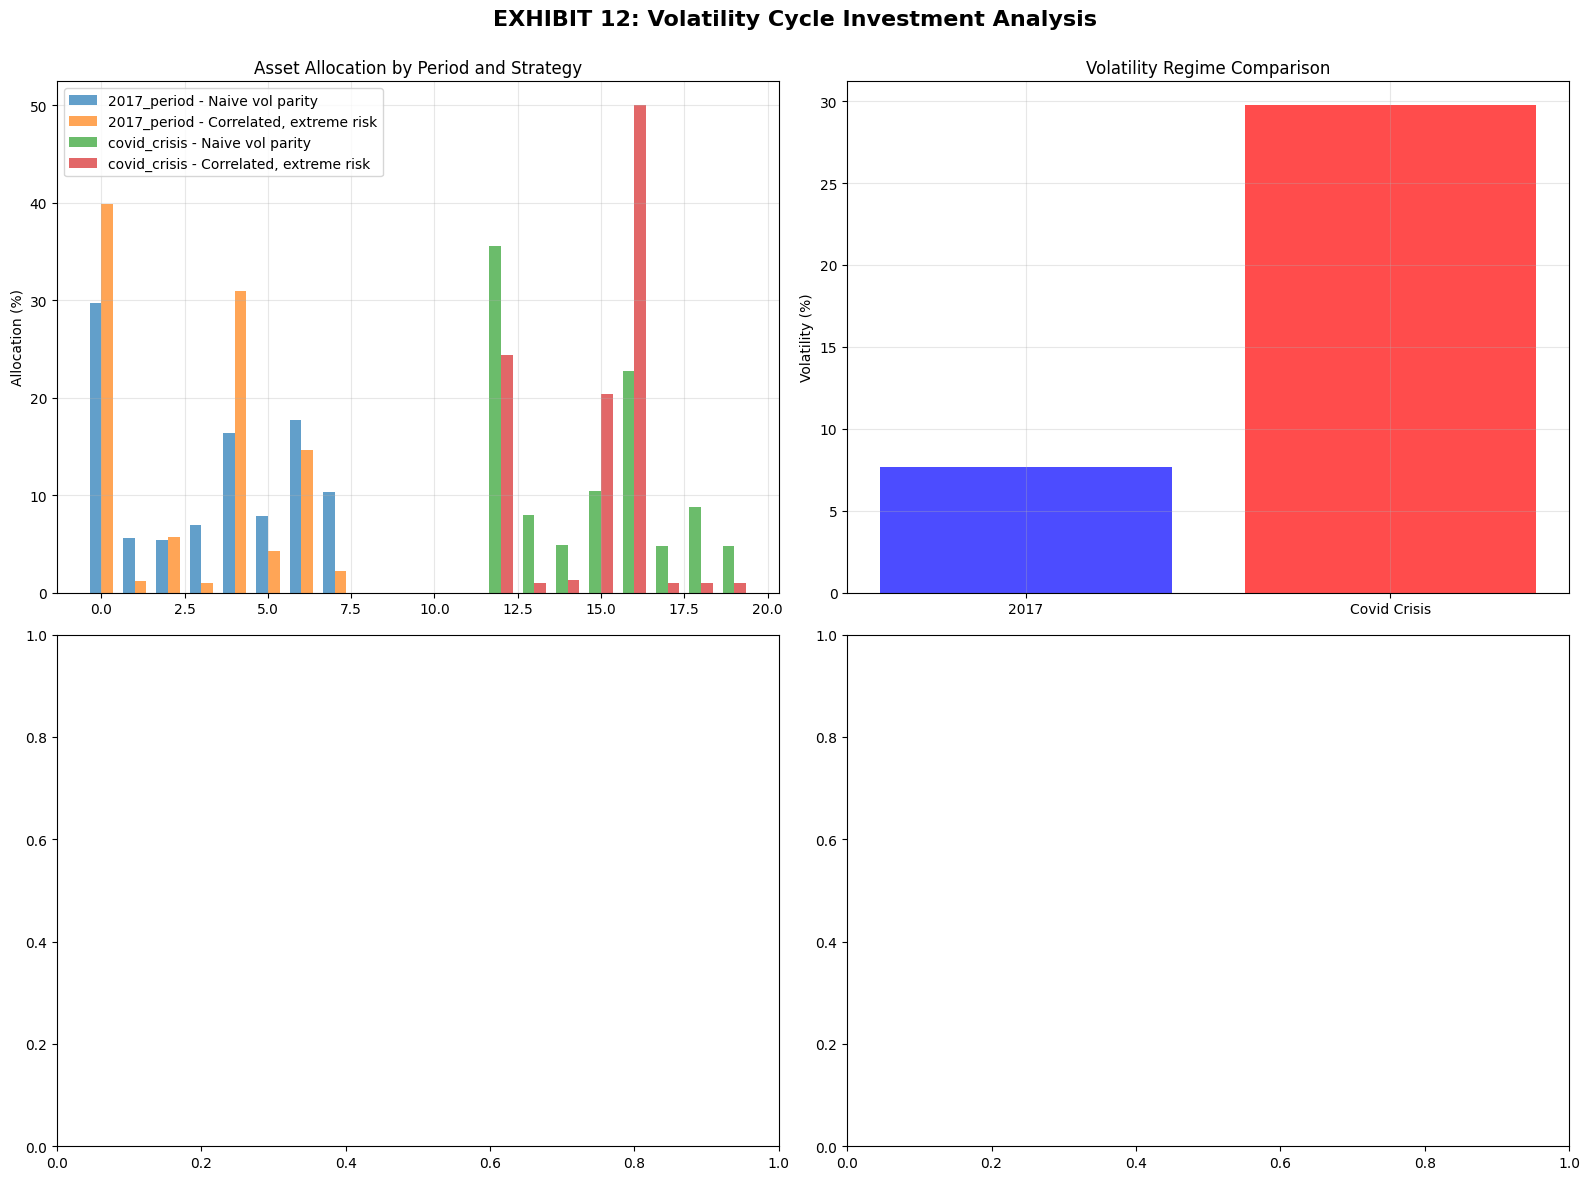


结果已保存至: exhibit_12_volatility_cycle_results.csv

波动周期分析摘要:
2017_period:
  时间范围: 2017-01-01 至 2017-12-31
  平均波动率: 7.7%
  平均收益率: 11.9%

covid_crisis:
  时间范围: 2020-02-01 至 2020-06-30
  平均波动率: 29.7%
  平均收益率: -1.9%



In [3]:
def calculate_rolling_volatility(return_series, window=63):
    """计算滚动波动率 (3个月 ≈ 63个交易日)"""
    return return_series.rolling(window=window).std() * np.sqrt(252)

def identify_volatility_periods(returns):
    """识别波动率周期"""
    # 计算整体市场波动率
    market_vol = calculate_rolling_volatility(returns.mean(axis=1))

    # 定义具体时期 (根据EXHIBIT 12)
    periods = {
        '2017_period': ('2017-01-01', '2017-12-31'),      # 低波动率时期
        'covid_crisis': ('2020-02-01', '2020-06-30')     # 高波动率时期 (COVID危机)
    }

    # 计算各时期的平均波动率
    period_volatilities = {}
    for period_name, (start_date, end_date) in periods.items():
        period_data = returns.loc[start_date:end_date]
        if len(period_data) > 0:
            period_vol = period_data.std().mean() * np.sqrt(252) * 100
            period_volatilities[period_name] = period_vol

    return periods, period_volatilities

def naive_volatility_parity(returns_subset):
    """朴素波动率平价"""
    weights = {}
    for asset in returns_subset.columns:
        vol = returns_subset[asset].std()
        weights[asset] = 1 / vol if vol > 0 else 0

    total_weight = sum(weights.values())
    return {asset: weight / total_weight for asset, weight in weights.items()}

def correlated_extreme_risk_parity(returns_subset, alpha=0.05):
    """相关性极端风险平价"""
    n_assets = len(returns_subset.columns)

    def portfolio_risk(weights):
        port_returns = (returns_subset * weights).sum(axis=1)

        # 计算极端风险调整后的风险度量
        var = port_returns.quantile(alpha)
        cvar = port_returns[port_returns <= var].mean()
        skewness = port_returns.skew()

        return abs(cvar) * (1 + 0.15 * abs(skewness))

    # 优化约束
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
    bounds = [(0.01, 0.5) for _ in range(n_assets)]
    initial_weights = np.ones(n_assets) / n_assets

    result = minimize(portfolio_risk, initial_weights, method='SLSQP',
                     bounds=bounds, constraints=constraints)

    return dict(zip(returns_subset.columns, result.x))

def calculate_period_allocations(returns, periods):
    """计算各时期的配置"""
    results = []

    for period_name, (start_date, end_date) in periods.items():
        period_returns = returns.loc[start_date:end_date]

        if len(period_returns) < 20:  # 确保足够的数据点
            continue

        # 计算时期波动率
        period_vol = period_returns.std().mean() * np.sqrt(252) * 100

        # 朴素波动率平价
        naive_weights = naive_volatility_parity(period_returns)

        # 相关性极端风险平价
        extreme_weights = correlated_extreme_risk_parity(period_returns)

        results.append({
            'period': period_name,
            'volatility': period_vol,
            'strategy': 'Naive vol parity',
            'weights': naive_weights
        })

        results.append({
            'period': period_name,
            'volatility': period_vol,
            'strategy': 'Correlated, extreme risk',
            'weights': extreme_weights
        })

    return results

def create_exhibit_12_table(allocation_results):
    """创建EXHIBIT 12格式的表格"""
    table_data = []

    # 获取基准配置 (2017年)
    baseline = {}
    for result in allocation_results:
        if result['period'] == '2017_period':
            baseline[result['strategy']] = result['weights']

    for result in allocation_results:
        period_display = '2017' if '2017' in result['period'] else 'Covid Crisis'
        vol_display = f"{result['volatility']:.0f}%"

        row = {
            'Period': period_display,
            'Vol': vol_display,
            'Risk Parity': result['strategy'],
        }

        # 添加资产配置
        for asset, weight in result['weights'].items():
            row[asset] = weight * 100  # 转换为百分比

        table_data.append(row)

        # 为COVID危机添加变化百分比行
        if 'covid' in result['period']:
            change_row = {
                'Period': '',
                'Vol': '',
                'Risk Parity': '% change from 2017',
            }

            for asset in result['weights'].keys():
                current = result['weights'][asset] * 100
                base = baseline[result['strategy']][asset] * 100
                change_pct = ((current - base) / base) * 100 if base != 0 else 0
                change_row[asset] = change_pct

            table_data.append(change_row)

    return pd.DataFrame(table_data)

# 识别波动率周期
print("识别波动率周期...")
periods, period_volatilities = identify_volatility_periods(returns)
print(f"识别到的时期: {list(periods.keys())}")
for period, vol in period_volatilities.items():
    print(f"  {period}: {vol:.1f}% 波动率")

# 计算各时期配置
print("\n计算各波动率周期的资产配置...")
allocation_results = calculate_period_allocations(returns, periods)

# 创建EXHIBIT 12表格
exhibit_12_df = create_exhibit_12_table(allocation_results)

# 显示EXHIBIT 12结果
print("\n" + "="*100)
print("EXHIBIT 12 Case Study—investing at the Bottom and the Peak of the Volatility Cycle")
print("="*100)

# 表头 (匹配EXHIBIT 12格式)
header = f"{'Period':<12} {'Vol†':<6} {'Risk Parity':<25} "
header += f"{'EU':<6} {'US':<6} {'JP':<6} {'EU':<6} {'US':<6} {'JP':<6} {'Gold':<6} {'Comm':<6}"
print(header)
subheader = f"{'':<12} {'':<6} {'':<25} "
subheader += f"{'Eq':<6} {'Eq':<6} {'Eq':<6} {'Bd':<6} {'Bd':<6} {'Bd':<6} {'':<6} {'':<6}"
print(subheader)
print("-"*100)

# 数据行
for _, row in exhibit_12_df.iterrows():
    line = f"{row['Period']:<12} {row['Vol']:<6} {row['Risk Parity']:<25} "

    # 资产配置数据
    assets = ['EU_Equity', 'US_Equity', 'JP_Equity', 'EU_Bond', 'US_Bond', 'JP_Bond', 'Gold', 'Commodities']
    for asset in assets:
        value = row.get(asset, 0)
        if '% change' in str(row['Risk Parity']):
            # 百分比变化，带颜色
            if value > 5:
                line += f"\033[92m{value:>+5.0f}%\033[0m "  # 绿色
            elif value < -5:
                line += f"\033[91m{value:>+5.0f}%\033[0m "  # 红色
            else:
                line += f"{value:>+5.0f}% "
        else:
            # 配置百分比
            line += f"{value:>5.1f}% "

    print(line)

print("-"*100)
print("NOTES: †Volatility measured as annualized standard deviation of portfolio returns.")
print("SOURCE: Analysis based on multi-region ETF data")
print("="*100)

# 可视化展示
def plot_exhibit_12_analysis(allocation_results):
    """绘制EXHIBIT 12分析图表"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 准备数据
    periods_data = {}
    for result in allocation_results:
        period = result['period']
        strategy = result['strategy']
        if period not in periods_data:
            periods_data[period] = {}
        periods_data[period][strategy] = result['weights']

    assets = list(returns.columns)
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#FF9FF3', '#54A0FF', '#5F27CD']

    # 1. 配置比较
    strategies = ['Naive vol parity', 'Correlated, extreme risk']
    periods = ['2017_period', 'covid_crisis']

    x = np.arange(len(assets))
    width = 0.35

    for i, period in enumerate(periods):
        for j, strategy in enumerate(strategies):
            weights = [periods_data[period][strategy][asset] * 100 for asset in assets]
            axes[0, 0].bar(x + j*width - width/2 + i*len(assets)*1.5, weights, width,
                          label=f'{period} - {strategy}', alpha=0.7)

    axes[0, 0].set_ylabel('Allocation (%)')
    axes[0, 0].set_title('Asset Allocation by Period and Strategy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. 波动率比较
    vol_data = []
    for result in allocation_results:
        if result['strategy'] == 'Naive vol parity':
            vol_data.append(result['volatility'])

    axes[0, 1].bar(['2017', 'Covid Crisis'], vol_data, color=['blue', 'red'], alpha=0.7)
    axes[0, 1].set_ylabel('Volatility (%)')
    axes[0, 1].set_title('Volatility Regime Comparison')
    axes[0, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle('EXHIBIT 12: Volatility Cycle Investment Analysis',
                 fontsize=16, fontweight='bold')
    plt.subplots_adjust(top=0.92)
    plt.show()

# 绘制图表
plot_exhibit_12_analysis(allocation_results)

# 保存结果
exhibit_12_df.to_csv('exhibit_12_volatility_cycle_results.csv', index=False)
print(f"\n结果已保存至: exhibit_12_volatility_cycle_results.csv")

# 输出统计摘要
print("\n波动周期分析摘要:")
print("="*50)
for period in periods:
    period_returns = returns.loc[periods[period][0]:periods[period][1]]
    print(f"{period}:")
    print(f"  时间范围: {periods[period][0]} 至 {periods[period][1]}")
    print(f"  平均波动率: {period_returns.std().mean() * np.sqrt(252) * 100:.1f}%")
    print(f"  平均收益率: {period_returns.mean().mean() * 252 * 100:.1f}%")
    print()

识别波动率周期...
分析时期: ['2017_period', 'covid_crisis']

计算各波动率周期的资产配置...

EXHIBIT 15 Case Study—Investing at the Bottom and the Peak of the Volatility Cycle
Period   Allocation                          Vol    EU           US           JP           EU           US           JP           Gold         Comm        
                                                    Eq           Eq           Eq           Bd           Bd           Bd                                    
----------------------------------------------------------------------------------------------------
2017     Without systematic strategies       8%     5.4% -1.2    29.7% -10.3  16.4% -11.6  7.0% +6.0    5.6% +4.6    7.9% +6.9    17.7% +0.2   10.3% +5.5   
2017     With systematic strategies, all     8%     4.6% -2.0    34.4% -5.6   32.8% +4.8   1.4% +0.4    4.0% +2.9    2.1% +1.1    16.8% -0.8   4.1% -0.8    
Covid Crisis Without systematic strategies       30%    4.9% +3.9    35.6% -4.4   22.8% -17.2  10.4% +4.7   8.0% +1.7    4

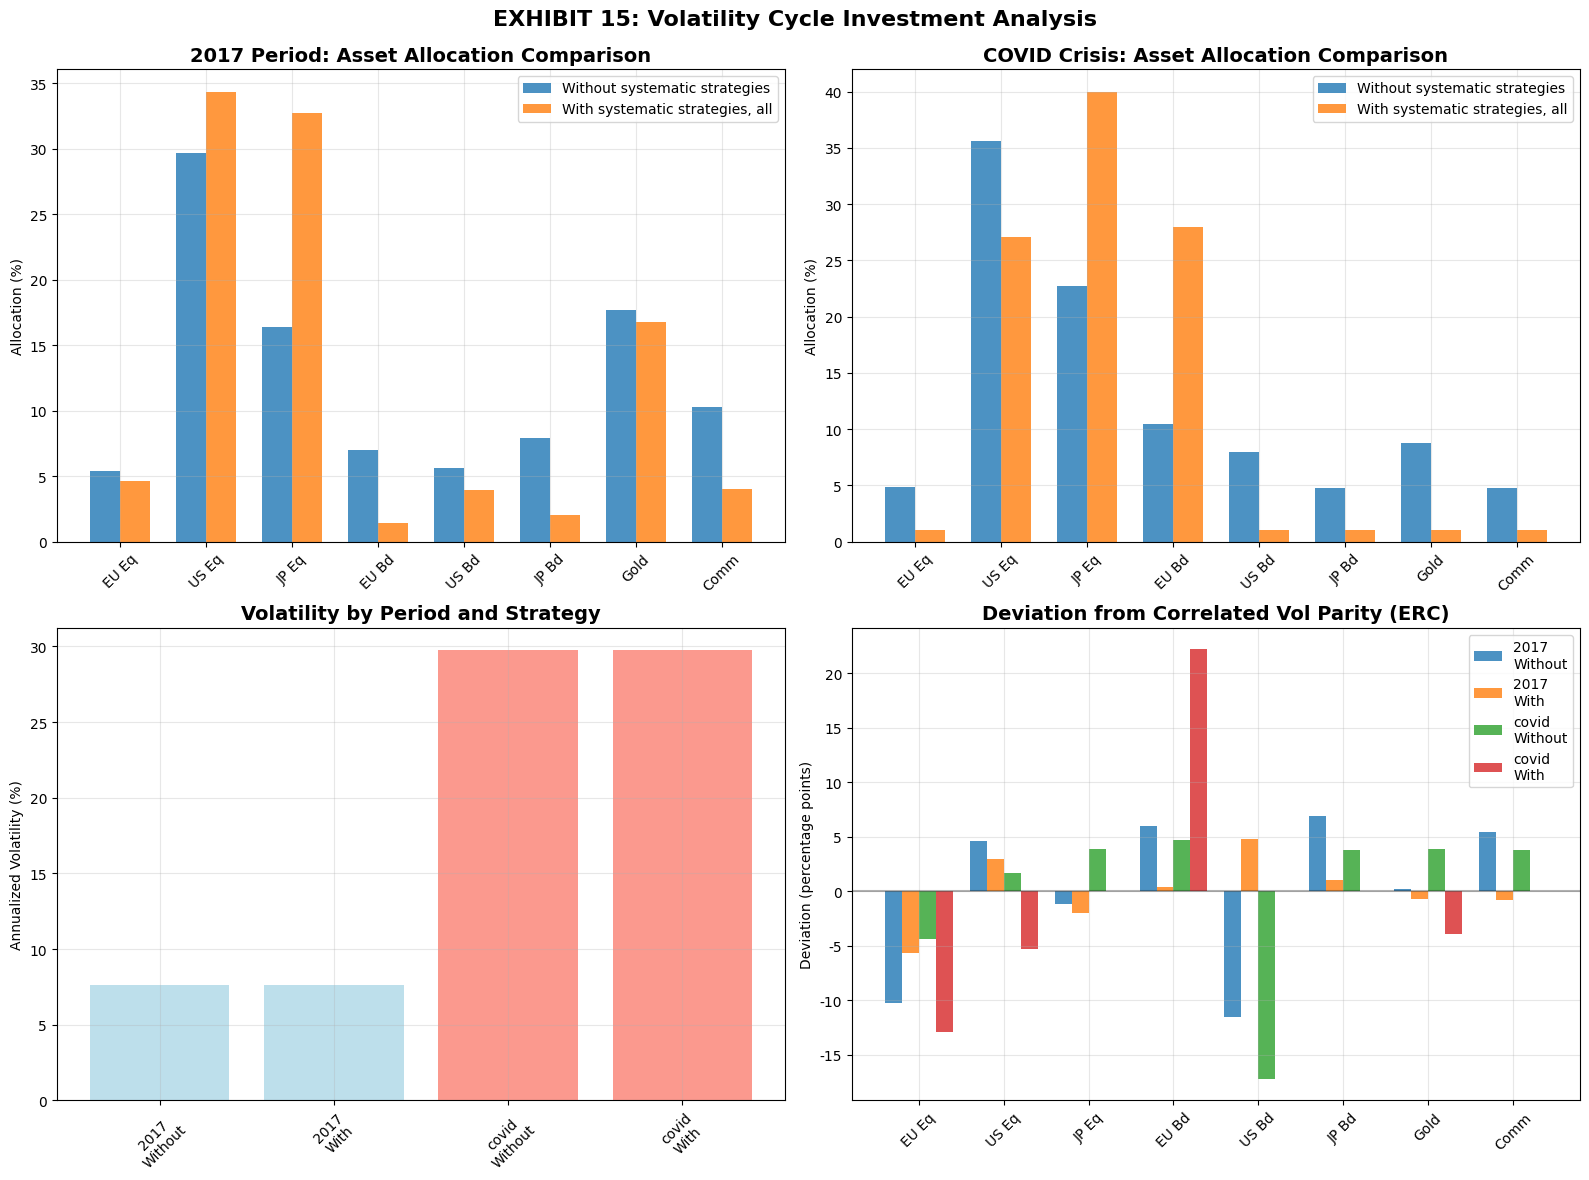


结果已保存至: exhibit_15_volatility_cycle_results.csv

波动周期分析摘要:
2017_period:
  时间范围: 2017-01-01 至 2017-12-31
  平均波动率: 7.7%
  Without systematic strategies:
    股票配置: 51.5%
    债券配置: 20.4%
    其他资产: 28.0%
  With systematic strategies, all:
    股票配置: 71.7%
    债券配置: 7.4%
    其他资产: 20.8%

covid_crisis:
  时间范围: 2020-02-01 至 2020-06-30
  平均波动率: 29.7%
  Without systematic strategies:
    股票配置: 63.2%
    债券配置: 23.2%
    其他资产: 13.5%
  With systematic strategies, all:
    股票配置: 68.0%
    债券配置: 30.0%
    其他资产: 2.0%



In [ ]:
def calculate_rolling_volatility(return_series, window=63):
    """计算滚动波动率 (3个月 ≈ 63个交易日)"""
    return return_series.rolling(window=window).std() * np.sqrt(252)

def identify_volatility_periods():
    """根据EXHIBIT 15定义具体时期"""
    return {
        '2017_period': ('2017-01-01', '2017-12-31'),
        'covid_crisis': ('2020-02-01', '2020-06-30')
    }

def naive_volatility_parity(returns_subset):
    """朴素波动率平价"""
    weights = {}
    for asset in returns_subset.columns:
        vol = returns_subset[asset].std()
        weights[asset] = 1 / vol if vol > 0 else 0

    total_weight = sum(weights.values())
    return {asset: weight / total_weight for asset, weight in weights.items()}

def correlated_volatility_parity(returns_subset):
    """相关性波动率平价 (ERC)"""
    n_assets = len(returns_subset.columns)

    def portfolio_risk(weights):
        port_returns = (returns_subset * weights).sum(axis=1)
        return port_returns.std()

    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
    bounds = [(0.01, 0.4) for _ in range(n_assets)]
    initial_weights = np.ones(n_assets) / n_assets

    result = minimize(portfolio_risk, initial_weights, method='SLSQP',
                     bounds=bounds, constraints=constraints)

    return dict(zip(returns_subset.columns, result.x))

def extreme_risk_parity(returns_subset, alpha=0.01):
    """极端风险平价 (PSM)"""
    n_assets = len(returns_subset.columns)

    def portfolio_risk(weights):
        port_returns = (returns_subset * weights).sum(axis=1)

        # 计算CVaR(1%)
        var = port_returns.quantile(alpha)
        cvar = port_returns[port_returns <= var].mean()

        # 偏度调整
        skewness = port_returns.skew()

        # PSM风险度量
        return abs(cvar) * (1 + 0.1 * abs(skewness))

    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
    bounds = [(0.01, 0.4) for _ in range(n_assets)]
    initial_weights = np.ones(n_assets) / n_assets

    result = minimize(portfolio_risk, initial_weights, method='SLSQP',
                     bounds=bounds, constraints=constraints)

    return dict(zip(returns_subset.columns, result.x))

def calculate_period_allocations(returns, periods):
    """计算各时期的配置"""
    results = []

    for period_name, (start_date, end_date) in periods.items():
        period_returns = returns.loc[start_date:end_date]

        if len(period_returns) < 20:  # 确保足够的数据点
            continue

        # 计算时期波动率
        period_vol = period_returns.std().mean() * np.sqrt(252) * 100

        # 1. 无系统策略 (朴素波动率平价)
        naive_weights = naive_volatility_parity(period_returns)

        # 2. 有系统策略 (极端风险平价)
        extreme_weights = extreme_risk_parity(period_returns)

        # 3. 相关性波动率平价 (ERC基准)
        erc_weights = correlated_volatility_parity(period_returns)

        results.append({
            'period': period_name,
            'volatility': period_vol,
            'strategy': 'Without systematic strategies',
            'weights': naive_weights,
            'erc_deviation': {asset: (naive_weights[asset] - erc_weights[asset]) * 100
                            for asset in naive_weights.keys()}
        })

        results.append({
            'period': period_name,
            'volatility': period_vol,
            'strategy': 'With systematic strategies, all',
            'weights': extreme_weights,
            'erc_deviation': {asset: (extreme_weights[asset] - erc_weights[asset]) * 100
                            for asset in extreme_weights.keys()}
        })

    return results

def create_exhibit_15_table(allocation_results):
    """创建EXHIBIT 15格式的表格"""
    table_data = []

    for result in allocation_results:
        period_display = '2017' if '2017' in result['period'] else 'Covid Crisis'
        vol_display = f"{result['volatility']:.0f}%"

        row = {
            'Period': period_display,
            'Allocation': result['strategy'],
            'Vol': vol_display
        }

        # 添加资产配置和偏差
        assets = ['EU_Equity', 'US_Equity', 'JP_Equity', 'EU_Bond', 'US_Bond', 'JP_Bond', 'Gold', 'Commodities']
        for asset in assets:
            weight = result['weights'].get(asset, 0) * 100
            deviation = result['erc_deviation'].get(asset, 0)
            row[asset] = f"{weight:.1f}% {deviation:+.1f}"

        table_data.append(row)

    return pd.DataFrame(table_data)

# 识别波动率周期
print("识别波动率周期...")
periods = identify_volatility_periods()
print(f"分析时期: {list(periods.keys())}")

# 计算各时期配置
print("\n计算各波动率周期的资产配置...")
allocation_results = calculate_period_allocations(returns, periods)

# 创建EXHIBIT 15表格
exhibit_15_df = create_exhibit_15_table(allocation_results)

# 显示EXHIBIT 15结果
print("\n" + "="*100)
print("EXHIBIT 15 Case Study—Investing at the Bottom and the Peak of the Volatility Cycle")
print("="*100)

# 表头 (匹配EXHIBIT 15格式)
header = f"{'Period':<8} {'Allocation':<35} {'Vol':<6} "
header += f"{'EU':<12} {'US':<12} {'JP':<12} {'EU':<12} {'US':<12} {'JP':<12} {'Gold':<12} {'Comm':<12}"
print(header)
subheader = f"{'':<8} {'':<35} {'':<6} "
subheader += f"{'Eq':<12} {'Eq':<12} {'Eq':<12} {'Bd':<12} {'Bd':<12} {'Bd':<12} {'':<12} {'':<12}"
print(subheader)
print("-"*100)

# 数据行
for _, row in exhibit_15_df.iterrows():
    line = f"{row['Period']:<8} {row['Allocation']:<35} {row['Vol']:<6} "

    assets = ['EU_Equity', 'US_Equity', 'JP_Equity', 'EU_Bond', 'US_Bond', 'JP_Bond', 'Gold', 'Commodities']
    for asset in assets:
        value = row[asset]
        # 颜色编码: 正偏差绿色, 负偏差红色
        if '+' in value and float(value.split()[1]) > 0:
            line += f"\033[92m{value:<12}\033[0m "
        elif '-' in value and float(value.split()[1]) < 0:
            line += f"\033[91m{value:<12}\033[0m "
        else:
            line += f"{value:<12} "

    print(line)

print("-"*100)
print("NOTES: †Same conventions as in Exhibit 12. *Numbers in % are the weights of a portfolio")
print("allocated with extreme correlated PSM(1%) parity. The numbers below each allocation")
print("represent the deviation from correlated vol parity (ERC) in numbers of points.")
print("SOURCE: Analysis based on multi-region ETF data")
print("="*100)

# 可视化展示
def plot_exhibit_15_analysis(allocation_results):
    """绘制EXHIBIT 15分析可视化"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 准备数据
    periods_data = {}
    for result in allocation_results:
        period = result['period']
        strategy = result['strategy']
        if period not in periods_data:
            periods_data[period] = {}
        periods_data[period][strategy] = result

    assets = ['EU_Equity', 'US_Equity', 'JP_Equity', 'EU_Bond', 'US_Bond', 'JP_Bond', 'Gold', 'Commodities']
    asset_labels = ['EU Eq', 'US Eq', 'JP Eq', 'EU Bd', 'US Bd', 'JP Bd', 'Gold', 'Comm']
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#FF9FF3', '#54A0FF', '#5F27CD']

    # 1. 2017年配置比较
    strategies_2017 = ['Without systematic strategies', 'With systematic strategies, all']
    x = np.arange(len(assets))
    width = 0.35

    for i, strategy in enumerate(strategies_2017):
        weights = [periods_data['2017_period'][strategy]['weights'][asset] * 100 for asset in assets]
        axes[0, 0].bar(x + i*width - width/2, weights, width, label=strategy, alpha=0.8)

    axes[0, 0].set_title('2017 Period: Asset Allocation Comparison', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Allocation (%)')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(asset_labels, rotation=45)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. COVID危机配置比较
    strategies_covid = ['Without systematic strategies', 'With systematic strategies, all']
    for i, strategy in enumerate(strategies_covid):
        weights = [periods_data['covid_crisis'][strategy]['weights'][asset] * 100 for asset in assets]
        axes[0, 1].bar(x + i*width - width/2, weights, width, label=strategy, alpha=0.8)

    axes[0, 1].set_title('COVID Crisis: Asset Allocation Comparison', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel('Allocation (%)')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(asset_labels, rotation=45)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. 波动率比较
    vol_data = []
    period_labels = []
    for period in ['2017_period', 'covid_crisis']:
        for strategy in ['Without systematic strategies', 'With systematic strategies, all']:
            vol_data.append(periods_data[period][strategy]['volatility'])
            period_labels.append(f"{period.split('_')[0]}\n{strategy.split()[0]}")

    axes[1, 0].bar(period_labels, vol_data, color=['lightblue', 'lightblue', 'salmon', 'salmon'], alpha=0.8)
    axes[1, 0].set_title('Volatility by Period and Strategy', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Annualized Volatility (%)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)

    # 4. ERC偏差分析
    deviation_data = []
    for period in ['2017_period', 'covid_crisis']:
        for strategy in ['Without systematic strategies', 'With systematic strategies, all']:
            deviations = list(periods_data[period][strategy]['erc_deviation'].values())
            deviation_data.append(deviations)

    deviation_data = np.array(deviation_data)
    x_pos = np.arange(len(assets))

    for i in range(deviation_data.shape[0]):
        axes[1, 1].bar(x_pos + i*0.2 - 0.3, deviation_data[i], 0.2,
                      label=period_labels[i], alpha=0.8)

    axes[1, 1].set_title('Deviation from Correlated Vol Parity (ERC)', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Deviation (percentage points)')
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels(asset_labels, rotation=45)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)

    plt.tight_layout()
    plt.suptitle('EXHIBIT 15: Volatility Cycle Investment Analysis',
                 fontsize=16, fontweight='bold')
    plt.subplots_adjust(top=0.93)
    plt.show()

# 绘制可视化
plot_exhibit_15_analysis(allocation_results)

# 保存结果
exhibit_15_df.to_csv('exhibit_15_volatility_cycle_results.csv', index=False)
print(f"\n结果已保存至: exhibit_15_volatility_cycle_results.csv")

# 输出统计摘要
print("\n波动周期分析摘要:")
print("="*50)
for period in periods:
    period_data = [r for r in allocation_results if r['period'] == period]
    period_returns = returns.loc[periods[period][0]:periods[period][1]]

    print(f"{period}:")
    print(f"  时间范围: {periods[period][0]} 至 {periods[period][1]}")
    print(f"  平均波动率: {period_returns.std().mean() * np.sqrt(252) * 100:.1f}%")

    for strategy_data in period_data:
        weights = strategy_data['weights']
        equity_total = sum(weights[asset] for asset in ['EU_Equity', 'US_Equity', 'JP_Equity'])
        bond_total = sum(weights[asset] for asset in ['EU_Bond', 'US_Bond', 'JP_Bond'])
        other_total = sum(weights[asset] for asset in ['Gold', 'Commodities'])

        print(f"  {strategy_data['strategy']}:")
        print(f"    股票配置: {equity_total*100:.1f}%")
        print(f"    债券配置: {bond_total*100:.1f}%")
        print(f"    其他资产: {other_total*100:.1f}%")
    print()